In [89]:
"""
amm: Dictionary with Key = asset, Value = amt of asset
trade: Tuple with (Asset to sell, asset to collect, amt of asset to sell) 
    - from the AMMs pov
fee_type: fee structure to be implemented on trade
"""

'\namm: Dictionary with Key = asset, Value = amt of asset\ntrade: Tuple with (Asset to sell, asset to collect, amt of asset to sell) \n    - from the AMMs pov\nfee_type: fee structure to be implemented on trade\n'

In [6]:
import math
import numpy as np
import random
from scipy.stats import truncnorm
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\Sean\AppData\Local\Temp\ipykernel_20192\1000722893.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
def quote(amm, trade):
    """
    AB/L^2 = 1 doesn't actually need the bisection solver as there will always be a closed form solution
    These are the closed form solutions for each trade 
    """
    if trade[0] == "L":
        return np.sqrt(amm["A"] * amm["B"])
    elif trade[0] == "A":
        new_A = (amm["L"]**2) / amm["B"]
        new_B = (amm["L"]**2) / new_A
        return new_A, new_B
    else:
        new_B = (amm["L"]**2) / amm["A"]
        new_A = (amm["L"]**2) / new_B
        return new_B, new_A

In [477]:
def fee_calc(amm, trade, type):
    
    if type == "percentage":
        return 0.003
    
    elif type == "tiered":
        mean, sigma = 75, 50
        if trade[2] < (mean - sigma): return 0.0005
        elif trade[2] > (mean +  sigma): return 0.01
        return 0.003
    
    elif type == "naive triangle": 
        mean, sigma = 10, 5
        if trade[2] > (mean - sigma) and trade[2] < (mean + sigma): return 0.003
        elif trade[2] < (mean - sigma): return 0.01
        return 0.0005
    
    elif type == "triangle":
        # get delta x to set upper limit
        delta_x = amm[trade[0]] - quote(amm, trade)[0]
        delta_y = quote(amm, trade)[1] - amm[trade[1]]
        base_fee, min_fee, slope, X, Y = 0.003, 0.0001, -1, amm[trade[0]], amm[trade[1]]
        
        delta_val = ((Y + delta_y) / (X - max(base_fee, delta_x))) - (Y / X)

        end_fee = max([(min_fee), (base_fee + (slope * delta_val))])
        
        if end_fee != min_fee: return ((base_fee + end_fee) / 2)
        
        excess_change = (min_fee - (base_fee + (slope * delta_val)))
        total = base_fee - min_fee + excess_change
        return ((((base_fee + min_fee) / 2) * ((base_fee - min_fee) / total)) + (min_fee * (excess_change / total)))
    


In [291]:
def trade_calc(amm, trade, fee_type):
    # Add the amount of assets given to amm to AMM
    amm[trade[1]] += trade[2]

    fee = fee_calc(amm, trade, fee_type)
    amm[trade[0]] = quote(amm, trade)[0]
        
    return fee, amm

In [158]:
#btc = pd.read_csv("C:\\Users\\Sean\\Downloads\\SHIFT\\experiment\\crypto_data\\crypto_data\\btc-usd_2024-01-01_2024-03-01_1h.csv")["price"]
eth = pd.read_csv("C:\\Users\\Sean\\Downloads\\SHIFT\\experiment\\crypto_data\\crypto_data\\eth-usd_2024-01-01_2024-03-01_1h.csv")["price"]

print(btc)
print(eth)

0       42405.082709
1       42576.313761
2       42551.995094
3       42367.149738
4       42307.763371
            ...     
1435    61244.231424
1436    62094.256031
1437    61318.423809
1438    61173.429307
1439    61364.895330
Name: price, Length: 1440, dtype: float64
0       42405.082709
1       42576.313761
2       42551.995094
3       42367.149738
4       42307.763371
            ...     
1435    61244.231424
1436    62094.256031
1437    61318.423809
1438    61173.429307
1439    61364.895330
Name: price, Length: 1440, dtype: float64


In [1]:
def geometric_brownian_motion(mu, sigma, S0, T, N, dt):
    """
    Generate geometric brownian motion.

    Parameters:
        mu (float): Drift coefficient.
        sigma (float): Diffusion coefficient.
        S0 (float): Initial value.
        T (float): Terminal time.
        N (int): Number of time steps.
        dt (float): Time step size.

    Returns:
        numpy.ndarray: Simulated GBM path.
    """
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # Standard Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W 
    S = S0 * np.exp(X)  # Geometric Brownian motion
    return S

# Parameters
mu = 0 # Drift coefficient
sigma = 0.25  # Diffusion coefficient
S0 = btc[0]  # Initial value
T = 1.0  # Terminal time
N = 1440  # Number of time steps
dt = T / N  # Time step size

# Generate GBM path
gbm_path = geometric_brownian_motion(mu, sigma, S0, T, N, dt)

# Plot GBM path
plt.plot(np.linspace(0, T, N), gbm_path, label = "GBM")
plt.plot(np.linspace(0, T, N), btc, label = "BTC")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Geometric Brownian Motion')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'btc' is not defined

AMM {'A': 11761.413390962716, 'B': 8502.379490957985, 'L': 10000}
Fees {'A': 31.17251224247809, 'B': 39.2957103915331}


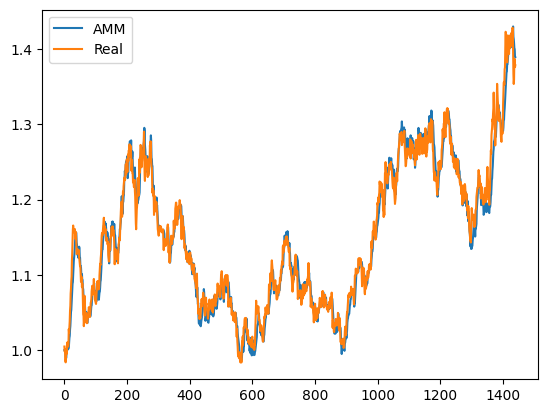

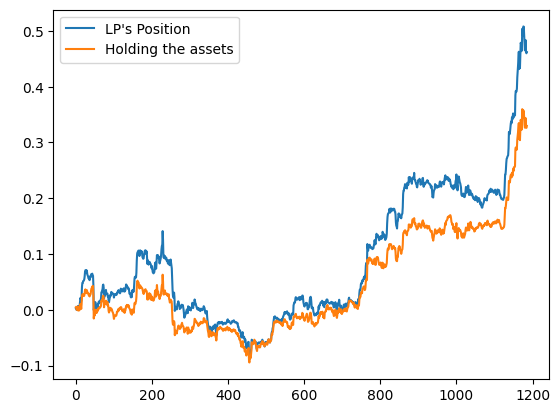

({'A': 31.17251224247809, 'B': 39.2957103915331},
 [0.004703161493714525,
  0.004070662621472376,
  -3.057277712481543e-05,
  0.0021890359082701316,
  0.0034040619105193404,
  0.006186016882030243,
  -0.0012888095683635248,
  0.002075930578954166,
  0.0012705789182299032,
  -0.0010517384656469897,
  0.0017568760449953036,
  0.006937632070979527,
  0.010375260891906546,
  0.007477901150524824,
  0.0015998284886558078,
  0.0098050043292508,
  0.023023399687652768,
  0.02763502505572424,
  0.026907433743949438,
  0.027510320470254923,
  0.02563583309778572,
  0.02460563727787335,
  0.025744427534739822,
  0.02931421643848431,
  0.03560555187569969,
  0.03657924578203753,
  0.03450585795512162,
  0.029812844124888604,
  0.033938106163655446,
  0.03519107525538612,
  0.030767005779711365,
  0.030852387159877148,
  0.02969699014118965,
  0.02728215728023131,
  0.026082127408042055,
  0.02638583767765379,
  0.02397296242465763,
  0.027945458562772307,
  0.02688586701593909,
  0.02967055585588

In [518]:
import random

AMM = {
    "A": 10000,
    "B": 10000,
    "L": 10000
}

def trade_environment(AMM, mean, sigma, a, b, A, B, acc_type, fee_type):
    AMM_er, real_er = [], []
    assets = ["A", "B"]
    choices = [0, 1]
    feesA = []
    feesB = []
    ratiosA = []
    ratiosB = []
    vols = []
    unrealized_rtrns, unrealized_vol = [], []
    MA_20, MA_50, MA_200 = {"A": [], "B": []}, {"A": [], "B": []}, {"A": [], "B": []}
    
    trade_sizes = truncnorm((a - mean) / sigma, (b - mean) / sigma, loc=mean, scale=sigma)
    port_val = []

    fees_collected = {
    "A": 0,
    "B": 0,
    }
    
    traders = {"Momentum": 0.0, 
                "Value": 0.0,}
        
    L = list(range(1, 50)) 
    port_val = []
    hold_val = []
    tracking = []
    for i, item in enumerate(A):
        
        AMM_er.append(AMM["A"] / AMM["B"])
        real_er.append(A[i] / B[i])
        
        tracking.append((abs(real_er[-1] - AMM_er[-1])))
                
        MA_20["A"].append(sum(A[max(i - 20, 0):i]) / min((i+1), 20))
        MA_20["B"].append(sum(B[max(i - 20, 0):i]) / min((i+1), 20))
        MA_50["A"].append(sum(A[max(i - 50, 0):i]) / min((i+1), 50))
        MA_50["B"].append(sum(B[max(i - 50, 0):i]) / min((i+1), 50))
        MA_200["A"].append(sum(A[max(i - 200, 0):i]) / min((i+1), 200))
        MA_200["B"].append(sum(B[max(i - 200, 0):i]) / min((i+1), 200))
        
        trades_i = []
        
        # Check momentum
        if MA_20["A"][-1] > (MA_50["A"][-1] * 1.05) and MA_20["B"][-1] < MA_50["B"][-1]:
            trades_i.append(["Momentum", ("A", "B", random.choice(L))])
        if MA_20["B"][-1] > (MA_50["B"][-1] * 1.05) and MA_20["A"][-1] < MA_50["A"][-1]:
            trades_i.append(["Momentum", ("B", "A", random.choice(L))])
            
        # Check value
        if MA_50["A"][-1] < MA_200["A"][-1] and MA_50["B"][-1] > MA_200["B"][-1]:
            trades_i.append(["Value", ("A", "B", random.choice(L))])
        if MA_50["B"][-1] < MA_200["B"][-1] and MA_50["A"][-1] > MA_200["A"][-1]:
            trades_i.append(["Value", ("B", "A", random.choice(L))])
            
        # Check arbitrage:
        if AMM_er[-1] > (real_er[-1] * 1.005):
            trades_i.append(["Arbitrage", ("A", "B", random.choice(L))])
        if (AMM_er[-1] * 1.005) < real_er[-1]:
            trades_i.append(["Arbitrage", ("B", "A", random.choice(L))])
            
           
        if trades_i == []: continue
        else: 
            trades_i_sizes = []
            for sublist in trades_i:
                # Calculate the last index and add it to the list of last indices
                trades_i_sizes.append(sublist[-1][-1])
        
        for j in range(len(trades_i)):
            if len(trades_i_sizes) == 0:
                continue
            elif len(trades_i_sizes) == 1:
                fee_charge, AMM = trade_calc(AMM, trades_i[j][1], fee_type)
                fees_collected[trades_i[0][1][0]] += (fee_charge * trades_i_sizes[0])
                if acc_type == "LP":
                    AMM[trades_i[0][1][0]] -= fee_charge
                    AMM["L"] = np.sqrt(AMM["A"] * AMM["B"])
                #port_val.append(((AMM["A"]/AMM["L"]) * underlying[i]) + (fees_collected["A"] + fees_collected["B"]))
                continue
            else:
                cur_trade = trades_i_sizes.index(min(trades_i_sizes))
                fee_charge, AMM = trade_calc(AMM, trades_i[cur_trade][1], fee_type)
                fees_collected[trades_i[0][1][0]] += (fee_charge * trades_i_sizes[cur_trade])
                if acc_type == "LP":
                    AMM[trades_i[0][1][0]] -= fee_charge * trades_i_sizes[cur_trade]
                    AMM["L"] = np.sqrt(AMM["A"] * AMM["B"])
                trades_i_sizes.pop(cur_trade)
        hold_val.append(((0.7 * A[i] + 0.3 * B[i])) / (0.7 * A[0] + 0.3 * B[0]) - 1)
        port_val.append(((((0.7 * ((AMM["A"] / AMM["L"]) * A[i] + fees_collected["A"])) 
                           + (0.3 * ((AMM["B"] / AMM["L"]) * B[i] + fees_collected["B"]))) 
                           / (0.7 * A[0] + 0.3 * B[0]))) - 1)
        
    print("AMM", AMM)
    print("Fees", fees_collected)
    
    
    plt.plot(AMM_er, label = "AMM")
    plt.plot(real_er, label = "Real")
    plt.legend()
    plt.show()
    
    plt.plot(port_val, label = "LP's Position")  
    plt.plot(hold_val, label = "Holding the assets")
    plt.legend()
    plt.show()
        
    return (fees_collected, hold_val, port_val, tracking)
# mu = 0 # Drift coefficient
# sigma = 0.25  # Diffusion coefficient
# S0 = btc[0]  # Initial value
# T = 1.0  # Terminal time
# N = 1440  # Number of time steps
# dt = T / N  # Time step size


# trade_environment(AMM, 10, 5, -2, 1998, btc, gbm_path, "accumulator", "triangle")

AMM {'A': 11717.416327793144, 'B': 8534.30459433321, 'L': 10000}
Fees {'A': 31.23108073141372, 'B': 37.687523731701965}


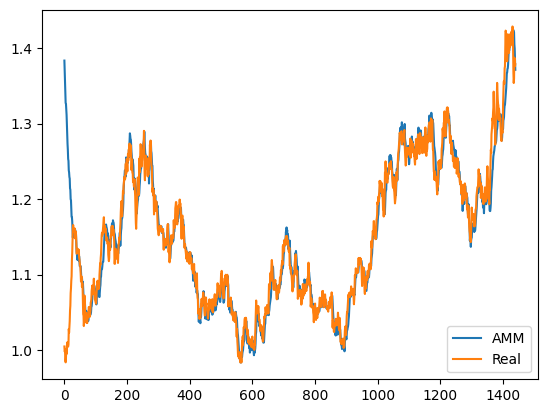

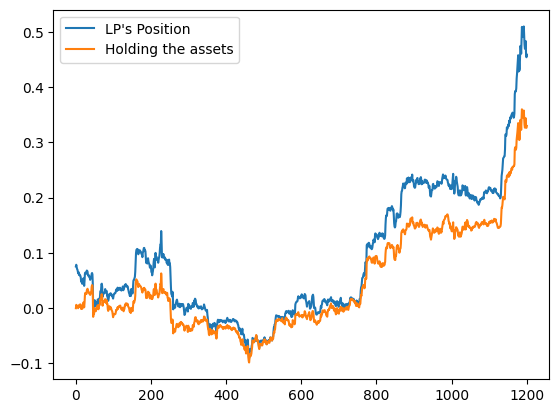

AMM {'A': 11723.70691011933, 'B': 8529.725347678634, 'L': 10000}
Fees {'A': 57.396000000000065, 'B': 70.68300000000039}


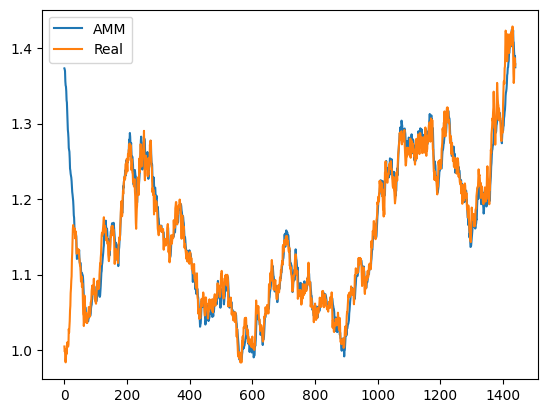

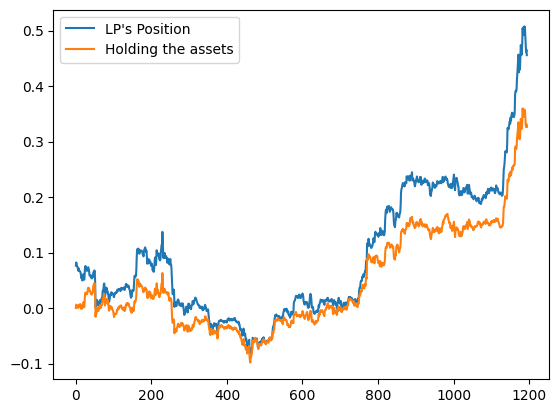

AMM {'A': 11748.621371275778, 'B': 8511.636969124747, 'L': 10000}
Fees {'A': 40.01600000000004, 'B': 47.616499999999945}


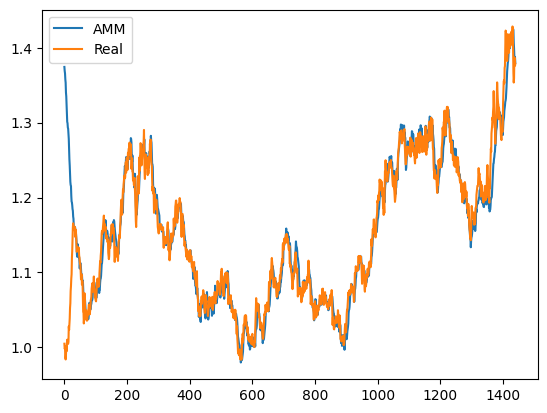

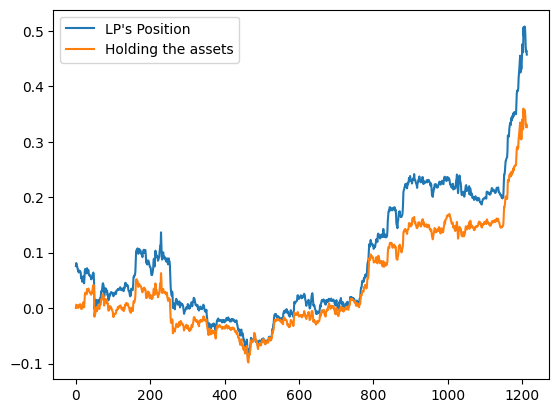

In [519]:
types = ["triangle", "percentage", "tiered"]

res = []
for item in types:
    res.append(trade_environment(AMM, 10, 5, -2, 1998, btc, gbm_path, "accumulator", item))

In [520]:
print("Excess Return Triangle:", res[0][2][-1] - res[0][1][-1])
print("Excess Return Percentage:", res[1][2][-1] - res[1][1][-1])
print("Excess Return Tiered:", res[2][2][-1] - res[2][1][-1])

print("")

print("Excess Triangle Volatility:", np.std(res[0][2]) - np.std(res[0][1]))
print("Excess Percentage Volatility:", np.std(res[1][2]) - np.std(res[2][1]))
print("Excess Tiered Volatility:", np.std(res[2][2]) - np.std(res[2][1]))

print("")

print("Triangle Average Tracking Error", sum(res[0][3]) / 1440)
print("Percentage Average Tracking Error", sum(res[1][3]) / 1440)
print("Tiered Average Tracking Error", sum(res[2][3]) / 1440)

Excess Return Triangle: 0.12877658548881832
Excess Return Percentage: 0.1294535023061376
Excess Return Tiered: 0.1309525625643646

Excess Triangle Volatility: 0.02706140975311154
Excess Percentage Volatility: 0.027824639852790822
Excess Tiered Volatility: 0.025933358011080626

Triangle Average Tracking Error 0.015693037305922437
Percentage Average Tracking Error 0.015790984666903613
Tiered Average Tracking Error 0.01612781041834286


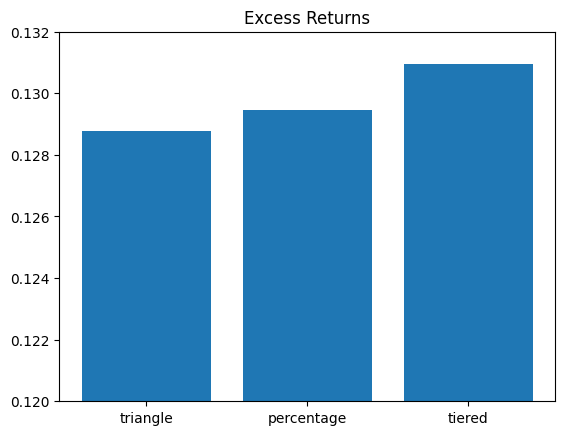

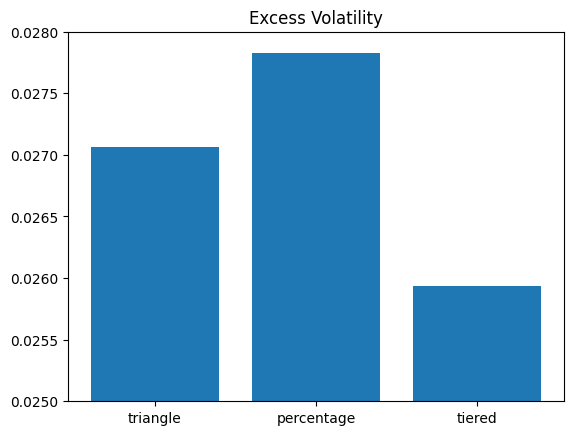

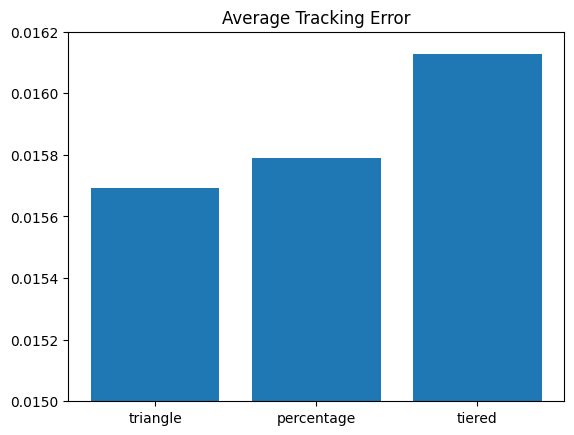

In [534]:
excess_rtrns = [res[0][2][-1] - res[0][1][-1], 
            res[1][2][-1] - res[1][1][-1],
            res[2][2][-1] - res[2][1][-1]]

excess_vol = [np.std(res[0][2]) - np.std(res[0][1]), 
              np.std(res[1][2]) - np.std(res[2][1]),
              np.std(res[2][2]) - np.std(res[2][1])]

tracking_err = [(sum(res[0][3]) / 1440),
                (sum(res[1][3]) / 1440),
                (sum(res[2][3]) / 1440)]

plt.bar(types, excess_rtrns)
plt.ylim(0.12, 0.132)
plt.title("Excess Returns")
plt.show()

plt.bar(types, excess_vol)
plt.ylim(0.025, 0.028)
plt.title("Excess Volatility")
plt.show()

plt.bar(types, tracking_err)
plt.ylim(0.015, 0.0162)
plt.title("Average Tracking Error")
plt.show()